In [ ]:
# how to use pytorch model zoo to instantiate these networks
# using the pre-trained models - transfer learning
# storing the intermediate models - while training while loss function is reducing there might be some
# oscillations and want to store intermediate models at points where the models have very low loss values
# but some how I moved out of them because of optimization algorithm
# after the training round is completed, can take very good solutions from that round
# and restart training from those points
# how to load the data sets and transform images
# how to resize the images when you are loading them and normalize the images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
# to find out whether there is actuall GPU or not in this particular instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Dataset, transform and visualization
# declare transform_train, transform_test objects
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

transform_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
# what is the need for normalization

In [4]:
# create the train dataset and transform
# CIFAR10 dataset has 32 X 32 images
# but standard networks takes input images of size 224 X 224
# hence the image sizes need to be blown up by resizing
# resizedcrop because, to preserve the aspect ration we might only want to look at crop rather than shrinking them unequally in different dimensions
# and the crop will be considered at random location from image
# it takes a random location and resizes to 224 X 224 and then crops it
# for CIFAR10 images it simply blows up the images to size of 224 X 224 - resizing and cropping in one go
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform = transform_train)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# create the test dataset and transform
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

Files already downloaded and verified


In [6]:
num_classes = 10

# for visualization consider a batch_size of 4
batch_size = 4

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [8]:
# instantiating iterator for train loader
# looking at one batch, .next() returns one batch
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
3


In [9]:
# plot the image
def imshow(img,title):
  # convert the image to numpy and unnormalize it
  # dividing it by 2 is equivalent to multiplying by 0.5 which is taking care of standard deviation
  # and then adding 0.5 which is nothing but compensating for mean
  npimg = img.numpy()/2 + 0.5
  plt.figure(figsize=(batch_size,1))
  plt.axis('off')
  # transpose - as we want in the order of horizontal, vertical and channels
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [10]:
# plot the image
def un_imshow(img,title):
  # convert the image to numpy and unnormalize it
  # dividing it by 2 is equivalent to multiplying by 0.5 which is taking care of standard deviation
  # and then adding 0.5 which is nothing but compensating for mean
  npimg = img.numpy()
  plt.figure(figsize=(batch_size,1))
  plt.axis('off')
  # transpose - as we want in the order of horizontal, vertical and channels
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [ ]:
# what happens if data is not unnormalized
# comment unnormalize logic and check the images
# you get the images that are too dark
# though the structural property exists, color property do not exists
# as the things are washed away 

In [11]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img,title=[str(x.item()) for x in labels])
  # un_imshow(img,title=[str(x.item()) for x in labels])

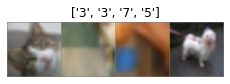

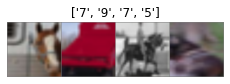

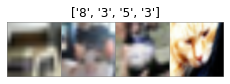

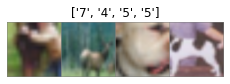

In [12]:
for i in range(batch_size):
  show_batch_images(trainloader)

In [13]:
# https://pytorch.org/docs/stable/torchvision/models.html
from torchvision import models

In [14]:
vgg = models.vgg16_bn()

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [17]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [19]:
# need to modify this network as there are 10 classes instead of 1000
# modify the classifier structure such that the out_features are 10
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features,num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [20]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [21]:
# train VGG
# if the batch size is large, during back propogation
# to update the weights at that particular layer during forward propogation
# and gradients of subsequent layers from back propogation, so you need to maintain outputs of all layers in GPU memory
# so larger batch sizes may result in out of memory error
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [22]:
def evaluation(dataloader,model):
  total, correct = 0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    return 100*correct/total

In [23]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(),lr=0.05)

In [24]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader,0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' %(
      epoch,max_epochs,
      evaluation(testloader,vgg), evaluation(trainloader,vgg)))
  
  plt.plot(loss_epoch_arr)
  plt.show()

Iteration: 0/3125, Loss: 2.81
Iteration: 100/3125, Loss: 2.25
Iteration: 200/3125, Loss: 2.22
Iteration: 300/3125, Loss: 2.31
Iteration: 400/3125, Loss: 2.40
Iteration: 500/3125, Loss: 2.50
Iteration: 600/3125, Loss: 2.40
Iteration: 700/3125, Loss: 2.26
Iteration: 800/3125, Loss: 2.29
Iteration: 900/3125, Loss: 2.28
Iteration: 1000/3125, Loss: 2.35


KeyboardInterrupt: ignored

In [ ]:
# one of the important things to figure out in deep learning is a sense of baseline for your results
# we got a loss of 2.81, is that high loss or low loss, what expectation should I have
# so find out the performance of random classifier, we have 10 classes and if we compute ln(10), it is  2.302
# a loss of 2.3 is what you expect a random classifier to have
# so we are starting with roughly how a random classifier would perform
# loss is fluctuating, as we need to optimize hyper parameters
# one thing is clear it is taking very long time for us to train
# lets see the practical ways to speed up this process
# VGG contains approximately 138M parameters
# instead of ,training it from scratch, we can use pre-trained models
# use the models pre trained on some network whose weights have been saved
# can re-use those weights and train only parts of the network

In [33]:
# freeze layers of convolution operations
# it not only instantiates different layers but also downloads 138M parameters trained on
# the Imagenet dataset
vgg = models.vgg16_bn(pretrained=True)

In [ ]:
# the torch version model zoo contains not only the model architecture
# but also the optimized weights and biases when trained for Imagenet Classification problem

In [34]:
# set the requires_grad attribute of each parameter as false
# if i am doing back propogation, dont go and update certain weight or bias
for param in vgg.parameters():
  param.requires_grad = False

In [35]:
# but some parameters needs to be opened up for training
# need to unfreeze certain parameters
# it creates new set of weights & bias parameters and by default sets them to require_grad = True
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features,num_classes)

In [40]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [36]:
#vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [41]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(),lr=0.05)

Iteration: 0/3125, Loss: 2.28
Iteration: 100/3125, Loss: 2.23
Iteration: 200/3125, Loss: 1.91
Iteration: 300/3125, Loss: 1.35
Iteration: 400/3125, Loss: 1.97
Iteration: 500/3125, Loss: 2.46
Iteration: 600/3125, Loss: 1.28
Iteration: 700/3125, Loss: 2.44
Iteration: 800/3125, Loss: 2.44
Iteration: 900/3125, Loss: 1.88
Iteration: 1000/3125, Loss: 2.96
Iteration: 1100/3125, Loss: 1.93
Iteration: 1200/3125, Loss: 2.54
Iteration: 1300/3125, Loss: 2.33
Iteration: 1400/3125, Loss: 1.67
Iteration: 1500/3125, Loss: 2.20
Iteration: 1600/3125, Loss: 1.89
Iteration: 1700/3125, Loss: 1.60
Iteration: 1800/3125, Loss: 1.72
Iteration: 1900/3125, Loss: 2.13
Iteration: 2000/3125, Loss: 2.40
Iteration: 2100/3125, Loss: 1.75
Iteration: 2200/3125, Loss: 1.37
Iteration: 2300/3125, Loss: 1.36
Iteration: 2400/3125, Loss: 2.33
Iteration: 2500/3125, Loss: 2.73
Iteration: 2600/3125, Loss: 2.61
Iteration: 2700/3125, Loss: 2.78
Iteration: 2800/3125, Loss: 0.62
Iteration: 2900/3125, Loss: 2.39
Iteration: 3000/3125, 

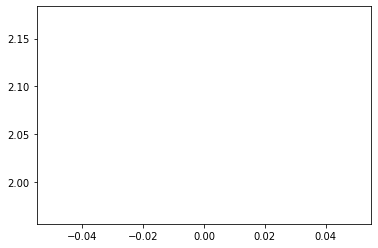

In [42]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader,0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' %(
      epoch,max_epochs,
      evaluation(testloader,vgg), evaluation(trainloader,vgg)))
  
  plt.plot(loss_epoch_arr)
  plt.show()